<a href="https://colab.research.google.com/github/PatriciaLucas/CNN/blob/master/Previsao_ETo_CNN_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference evapotranspiration prediction with individual multivariate CNN1 model

  


##Inports

In [44]:
# !pip install keras-tcn==2.8.3
# !git clone https://github.com/PatriciaLucas/CNN
# from CNN import Ensemble as es
# from CNN import basic
import Ensemble as es
import basic
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 7
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from math import sqrt

import warnings
# from google.colab import files
warnings.filterwarnings("ignore")

##Database

In [45]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

In [46]:
def get_search_dataset_multivariate(dataset, n_var):
    df1 = pd.read_csv(dataset, sep=',') # 7305 registros
    series = df1.iloc[:,1:n_var+1]
    norm_df = normalize(series)
    size = int(len(norm_df) * 0.80)
    train = series[:size]
    test = series[size:]
    return train, test

In [47]:
star_CNN1 = {'filters': 1, 'pool': 0, 'pool_size': 3, 'dropout': 0.012594059561340142, 'norm': 1, 'lags': 4, 'num_conv': 1, 'kernel_size': 3, 'rmse': 0.7696852129001718, 'num_param': 449}
# star_CNN2 = {'filters': 1, 'dropout': 0, 'norm': 1, 'lags': 4, 'num_conv': 1, 'kernel_size': 0, 'rmse': 0.7566198577347709, 'num_param': 449}
# star_CNN3 = {'pilhas': 2, 'filters': 1, 'dropout': 0.2, 'norm': 1, 'lags': 48, 'num_conv': 3, 'kernel_size': 2, 'rmse': 0.7530, 'num_param': 68257} 

### Multivariate CNN1

In [86]:
m_row_train, m_row_test = get_search_dataset_multivariate('lat-19.75_lon-44.45.csv', n_var=7)

In [ ]:
n_var = 7
test_set = []
predictions = []

m_train, m_test, m_scaler = es.get_dados(star_CNN1, m_row_train, m_row_test)
X_train, y_train, X_test, y_test = basic.slideWindowMulti(m_train, m_test, n_lags=star_CNN1['lags'], n_var=n_var)

model,_ = basic.modelo_CNN1(X_train, y_train, star_CNN1) 
rmse, yhat, y_test = basic.predictModelMulti(m_test, model, n_previsoes=1, n_lags=star_CNN1['lags'], n_var=n_var, scaler=m_scaler) # <- Ficar atento ao número de previsões à frente!!!

predictions = yhat
test_set = y_test

In [92]:
m_row_train, m_row_test = get_search_dataset_multivariate('multi_rs_lat-21.95_lon-46.65.csv', n_var=2)

In [88]:
n_var = 2
test_set = []
predictions = []

m_train, m_test, m_scaler = es.get_dados(star_CNN1, m_row_train, m_row_test)
X_train, y_train, X_test, y_test = basic.slideWindowMulti(m_train, m_test, n_lags=star_CNN1['lags'], n_var=n_var)
model,_ = basic.modelo_CNN1(X_train, y_train, star_CNN1) 
rmse, yhat, y_test = basic.predictModelMulti(m_test, model, n_previsoes=1, n_lags=star_CNN1['lags'], n_var=n_var, scaler=m_scaler)

Epoch 78: early stopping


In [89]:
test_set = y_test

predictions = yhat[:,0]

In [90]:
mae_cnn1 = mean_absolute_error(test_set, predictions)
print('Test MAE: %.3f' % mae_cnn1)

rmse_cnn1 = sqrt(mean_squared_error(test_set, predictions))
print('Test RMSE: %.3f' % rmse_cnn1)

mape_cnn1 = mean_absolute_percentage_error(test_set, predictions)
print('Test MAPE: %.3f' % mape_cnn1)

Test MAE: 0.444
Test RMSE: 0.606
Test MAPE: 0.168


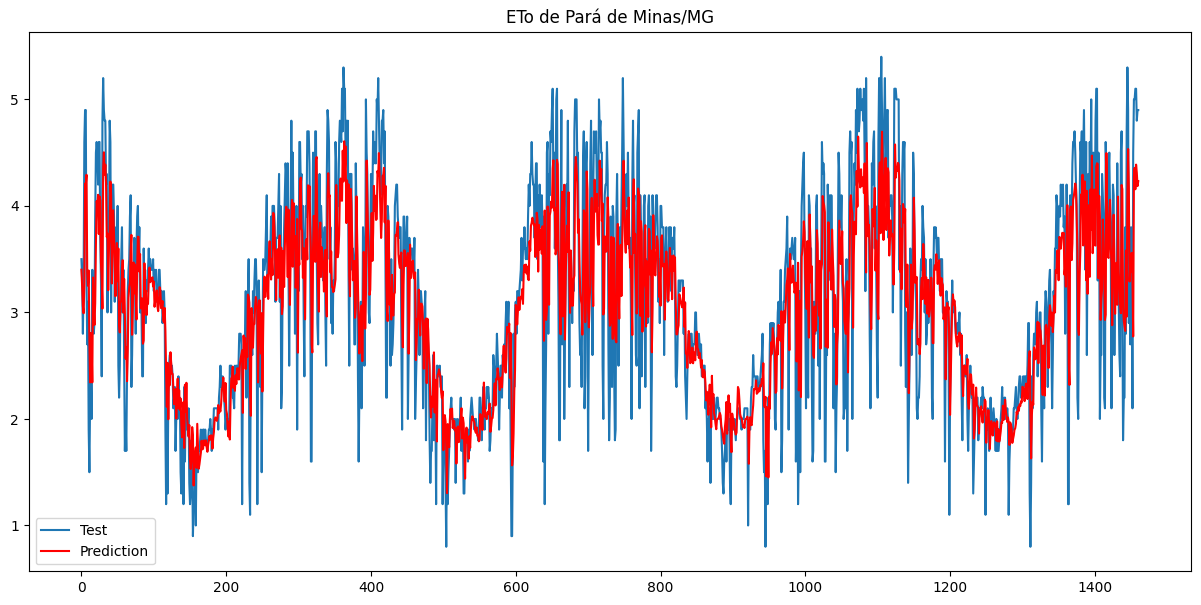

In [91]:
plt.title("ETo de Pará de Minas/MG")
plt.plot(test_set, label='Test')
plt.plot(predictions, color='red', label='Prediction')
plt.legend(loc='best')
plt.show()

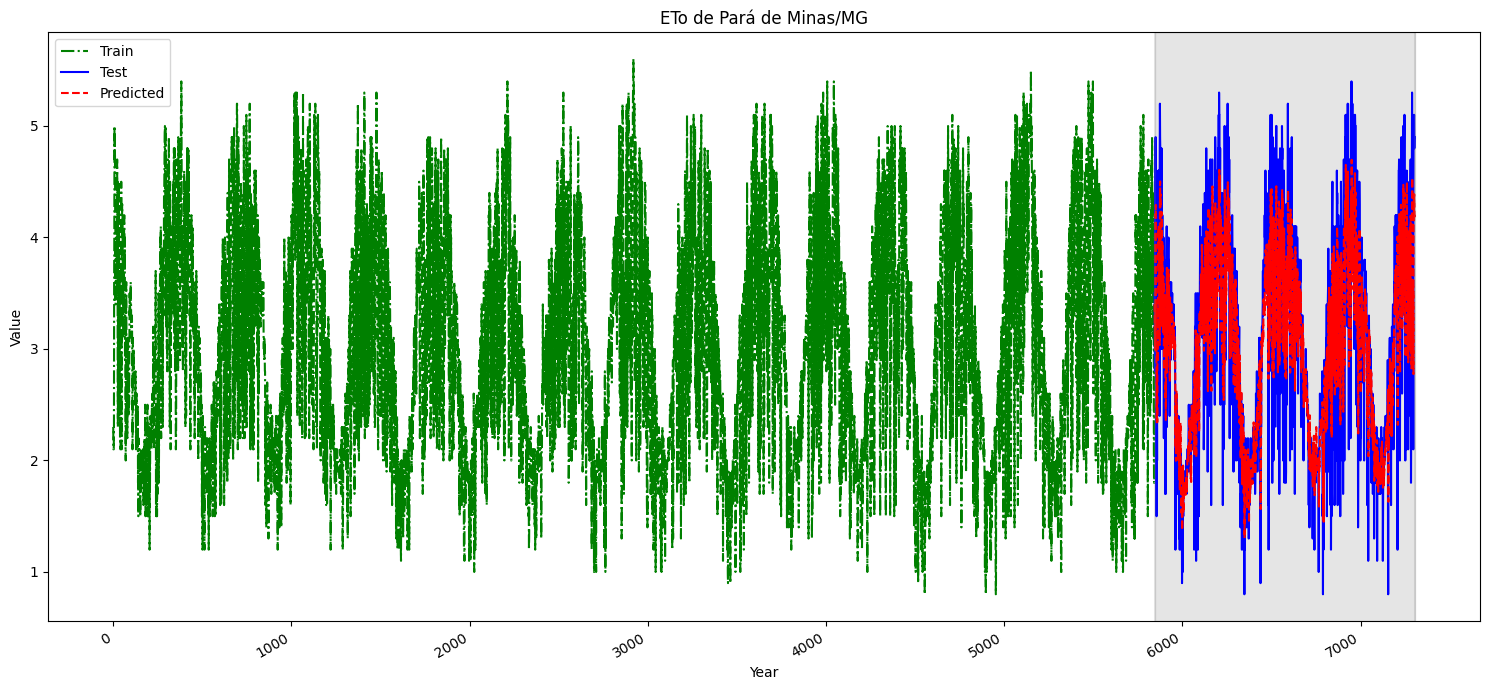

In [120]:
# Ilustrando graficamente o desempenho do modelo CNN1.

fig, ax = plt.subplots()

size = int(len((m_row_train)+len(m_row_test)))
total = size + len(m_row_test)

ax.plot(m_row_train['ETo'].index, m_row_train['ETo'], 'g-.', label='Train')
ax.plot(range(size, total), test_set, 'b-', label='Test')
ax.plot(range(size, total), predictions, 'r--', label='Predicted')

ax.legend(loc='best')

ax.set_xlabel('Year')
ax.set_ylabel('Value')

ax.axvline(size, color='#808080', linestyle='-', alpha=0.2)
ax.axvline(total, color='#808080', linestyle='-', alpha=0.2)
ax.axvspan(size, total, color='#808080', alpha=0.2) # zona cinza

plt.title("ETo de Pará de Minas/MG")

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
# metrics_names = ['mae_ar', 'mae_var_int', 'mae_var_ext', 'rmse_ar', 'rmse_var_int', 'rmse_var_ext', 'mape_ar', 'mape_var_int', 'mape_var_ext']
# metrics_values = [mae_ar, mae_var_int, mae_var_ext, rmse_ar, rmse_var_int, rmse_var_ext, mape_ar,   mape_var_int,   mape_var_ext]
# colors = ['tab:red', 'tab:blue', 'tab:orange']
# bar_labels = ['AR ETo Principal', 'VAR Parâmetros Meteorológicos ETo Principal', 'VAR ETos em torno da ETo Principal', '_AR ETo Principal', '_VAR Parâmetros Meteorológicos ETo Principal', '_VAR ETos em torno da ETo Principal', '_AR ETo Principal', '_VAR Parâmetros Meteorológicos ETo Principal', '_VAR ETos em torno da ETo Principal']

# fig, ax = plt.subplots()

# bar_container = ax.bar(metrics_names, metrics_values, color=colors, label=bar_labels)
# ax.set(ylabel='Values', xlabel='Metrics', title='Assessment Results') #, ylim=(0, 100))
# ax.bar_label(bar_container, fmt='{:,.2f}')
# ax.legend(title='Models')